# News spreading on youtube from US Channels


## Table of Contents
* [1 Preprocessing and data filtering](#filter_data)
    * [1.1 Filter for Category 'News & Politics'](#filter_data-category)
    * [1.2 Filter for Active Channels](#filter_data-active)
    * [1.3 Get country of channel](#filter_data-country)
    * [1.4 Get if channel is english-speaking](#filter_data-english)
    * [1.5 Filter for language and country and save final data](#filter_data-save)
        * [1.5.1 Filtering relevant comments](#filter_data-comments)
* [2 Selection of Events and filtering for relevant videos](#event_selection)
* [3 How US News report on different events](#status_quo)
    * [3.1 Get relevant videos per event](#status_quo-videos_per_event)
    * [3.2 Extract video and channel features](#status_quo-features)
        * [3.2.1 Intial distribution of video metrics](#status_quo-features-distributions)
    * [3.3 Results and Comparison between Events](#status_quo-results)
* [4 How does the public response to events](#public_response)
    * [4.1 Compute Public Response Metrics](#public_response-metrics)
    * [4.2 Compute Correlation between Video Features and Response Metrics](#public_response-correlation)
    * [4.3 Compute F- and T-tests](#public_response-ttest)
* [5 Conclusion](#conclusion)

**Global imports**

In [12]:
import pandas as pd
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
from datetime import date
import matplotlib.dates as mdates
import importlib



from src.utils import keywords
from src.utils import analysis_tools
from src.scripts import filters, filter_comments
from src.plot_utils import channel_activity, filtering_visualization
# from src.utils import general_utils

**Path definitions**

In [ ]:
# Path to raw files used for preprocessing
path_data_dir = 'data/'

path_df_channels_en = 'data/df_channels_en.tsv'

path_df_timeseries = 'data/df_timeseries_en.tsv'

path_yt_metadata_feather = 'data/yt_metadata_helper.feather'
path_yt_metadata_feather_filtered = 'data/filtered_yt_metadata_helper.feather.csv'

path_yt_metadata = 'data/yt_metadata_en.jsonl'
path_yt_metadata_filtered = 'data/filtered_yt_metadata.csv'

path_comments_filtered = 'data/filtered_comments.csv'
path_comments_filtered_copy = 'data/filtered_comments_copy.csv'
path_comments_stats = "data/comment_stats.csv"


# Path of preprocessed files used for event selection
path_final_channels = 'data/final_channels.csv'
path_final_timeseries = 'data/final_timeseries.csv'
path_final_yt_metadata_feather = 'data/final_yt_metadata_helper.csv'
path_final_yt_metadata = 'data/final_yt_metadata.csv'

# Path of event-filtered files, used for analysis
path_event_yt_metadata = 'data/final_classified_filtered_dataset.csv'


path_final_all_features_and_metrics = "data/final_all_features_and_metrics.csv"
path_subjectivity = "data/videos_subjectivity.csv"

## 1 Preprocessing and data filtering  <a class="anchor" id="filter_data"></a>

The most important part of the data analysis is to question how we get the videos related to our questions. So how can we get the videos from US news channels? And how can we find the related videos to the events out of all the videos from those channels?

The first question is easier to answer, to get the releveant US news channels we did a filtering in 4 steps:
1. Only consider channels which are categorized as 'News & Politics'. The category corresponds to the most frequent category (set per video by the channel) present on the channel.
2. As we are interested in News updates we only consider channels showing a high average activity. This we set to be more than 4 videos per day.
3. We exclude any non-english speaking channels.
4. We exclude any non-US channels.

The second question is trickier to answer, as there are a lot of parameters to consider. The detailed approach is described in section [2](#status_quo).

### 1.1 Filter for Category 'News & Politics' <a class="anchor" id="filter_data-category"></a>

The first step for filtering our data is to select only the channels which have been categorized as 'News & Politics'. This is done using `df_channels_en.tsv`.

In [3]:
pl_df_ch = pl.read_csv(path_df_channels_en, separator="\t")

filtered_df_ch = filters.filter_df(pl_df_ch, column_name="category_cc", 
                                   value="News & Politics", cmpstr="==")

print(f"Number of channels in category 'News & Politics': {len(filtered_df_ch)}")

Number of channels in category 'News & Politics': 2263


### 1.2 Filter for Active Channels <a class="anchor" id="filter_data-active"></a>

As we only want to focus on channels providing News Updates, we will compute the average activity of channel. This is defined as the average number of videos uploaded over two weeks and computed using the `df_timeseries_en.tsv`. We assumed that channels providing news *updates* will upload several videos per day. A manual review of some channels verified this assumption. To set a threshold we will plot the distribution to see if there is a clear separation between active and inactive channels. 

In [4]:
df_timeseries = pl.read_csv(path_df_timeseries, separator="\t")

# filter timeseries for channels in category 'News & Politics'
filtered_df_timeseries = filters.filter_df_isin(df_timeseries, column_name="channel", 
                                                values=filtered_df_ch["channel"])

In [ ]:
# compute the average activity for all channels and merge with the filtered channels by category
grouped_df = filtered_df_timeseries.group_by('channel').agg(pl.col('activity').mean().alias('mean_activity'))
filtered_df_timeseries = filtered_df_ch.join(grouped_df, on='channel', how='inner')
filtered_df_timeseries.head(2)

category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,mean_activity
str,str,str,str,i64,i64,f64,f64,f64
"""News & Politics""","""2006-08-26""","""UCttspZesZIDEwwpVIgoZtWQ""","""IndiaTV""",15177282,139814,199.0,2.087,596.564103
"""News & Politics""","""2012-06-01""","""UCRWFSbif-RFENbBrSiez1DA""","""ABP NEWS""",16274836,129027,207.0,2.087,595.458065


#### Activity Distribution

Here we plot the distribution of the average number of videos uploaded over two weeks for all channels. We want to see if there are clear separation between active and inactive channels to set a threshold.

**Conclusion**: 
But by looking at the distribution below (left plot) we cannot identify clusters of active and non-active channels. That's why we set the cutoff threshold manually choosing a reasonable activity as threshold as 4 videos per day. This was verified manually by checking channels above the threshold (list on the right). They mainly correspond to the type of news channels we were looking for such as CNN, Fox News, ABC News, etc.

In [ ]:
channel_activity.plot_channel_activity(pl_df_ch, df_timeseries, show=True, save_path='channels_activity_histogram.html')

#### Filter channels by activity

In [ ]:
# merge with channels dataframe
filtered_df_ch = filtered_df_ch.join(grouped_df, on="channel", how="inner")

# 56 = 4 videos per day x 14 days
filtered_df_ch = filters.filter_df(filtered_df_ch, "mean_activity", 56, ">")

# filtered_df_ch.sort(by="mean_activity", descending=True).head(10)

print("Number of channels in category 'News & Politics' with more than 4 videos per",\
      f"day: {len(filtered_df_ch)}")

Number of channels in category 'News & Politics' with more than 4 videos per day: 407


#### Intermediate Step: Filter yt_metadata by channels obtained before
To reduce the size of the big datasets `yt_metadata_en.jsonl` and `yt_metadata_helper.feather` we will prefilter them using the channels we obtained before. This will reduce the size of the dataset and make it easier to work with in future.

In [4]:
# Transform feather into csv to ease handling
df_vd_f = pd.read_feather(path_yt_metadata_feather)
# save to csv
df_vd_f.to_csv(path_yt_metadata_feather+".csv", sep="\t", index=False)

In [ ]:
# filter yt_metadata_helper.feather.csv by highly active news channels
filters.df_filter_csv_batched(path_yt_metadata_feather+".csv", path_yt_metadata_feather_filtered,
                              column_name="channel_id", values=filtered_df_ch["channel"],
                              filter_method="is_in")

In [ ]:
# Test if filtering worked by reading the previous saved file and printing the number of videos remaining
filtered_df_metadata_feather = pl.read_csv(path_yt_metadata_feather_filtered)
print("Number of videos from channels of interest (CoI): "\
      f"{len(filtered_df_metadata_feather)}")

Number of videos from channels of interest (CoI): 6812344


In [ ]:
# same process for yt_metadata_en.jsonl
# we will also transform this file into a csv to unify file formats
filters.df_filter_jsonl_batched(path_yt_metadata, path_yt_metadata_filtered, 
                                column_name="channel_id", 
                                values=filtered_df_ch["channel"],
                                sep="\t", batch_size=500)

### 1.3 Get country of channel <a class="anchor" id="filter_data-country"></a>

With the Youtube API we can query for the country information with the channel ID 

In [ ]:
high_activity_channels = filtered_df_ch.with_columns(
    pl.col("channel").map_elements(lambda channel_id:general_utils.get_channel_country(channel_id)).alias("Channel_country")
)

C:\Users\jeffr\AppData\Local\Temp\ipykernel_25620\2021680753.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  high_activity_channels = high_activity_channels.with_columns(


#### Example of filtered channel dataframe with country

In [ ]:
high_activity_channels.write_csv("data/high_activity_channels_with_country")
print(high_activity_channels.sample(10))


shape: (10, 10)
┌────────────┬───────────┬───────────┬───────────┬───┬───────────┬─────────┬───────────┬───────────┐
│ category_c ┆ join_date ┆ channel   ┆ name_cc   ┆ … ┆ subscribe ┆ weights ┆ mean_acti ┆ Channel_c │
│ c          ┆ ---       ┆ ---       ┆ ---       ┆   ┆ r_rank_sb ┆ ---     ┆ vity      ┆ ountry    │
│ ---        ┆ str       ┆ str       ┆ str       ┆   ┆ ---       ┆ f64     ┆ ---       ┆ ---       │
│ str        ┆           ┆           ┆           ┆   ┆ f64       ┆         ┆ f64       ┆ str       │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═════════╪═══════════╪═══════════╡
│ News &     ┆ 2017-02-1 ┆ UCMYlXK0j ┆ 10News    ┆ … ┆ 520837.0  ┆ 9.63    ┆ 93.886179 ┆ US        │
│ Politics   ┆ 7         ┆ yerVnc3dm ┆ WTSP      ┆   ┆           ┆         ┆           ┆           │
│            ┆           ┆ z-vjCA    ┆           ┆   ┆           ┆         ┆           ┆           │
│ News &     ┆ 2011-07-0 ┆ UCczsYSRG ┆ Himalaya  ┆ … ┆ 32797.0   ┆ 3.2005  

### 1.4 Get if channel is english-speaking with CHATGPT LLM API <a class="anchor" id="filter_data-english"></a>

Task: Use `filtered_yt_metadata.csv` and `high_activity_channels_with_country.csv` to filter for english videos

Since the youtube metadata dataset contains videos that are not from english speaking channels, we need to do further processing. We use the CHATGPT API to analyze 5 videos and descriptions and if **any** video is not classified as english, the channel is marked as non-english.

This step is done even though the Youniverse dataset should already contain only english videos. LLM improved a lot in the past four years and since some of the channels we get are Hindi or Spanish, we expect to get a cleaner dataset by classifying them using a LLM.

#### Finding 5 videos that correspond to the high activity channels

In [ ]:
channels_df = pd.read_csv("data/high_activity_channels_with_country.csv") 
channel_ids = set(channels_df['channel'].unique())  
chunk_reader = pd.read_csv("data/filtered_yt_metadata.csv", chunksize=5000)

matching_videos = []
# dictionary to track how many videos are saved for each channel
channel_video_count = {channel_id: 0 for channel_id in channel_ids}

for chunk in chunk_reader:
    matching_rows = chunk[chunk['channel_id'].isin(channel_ids)]
    for channel_id, group in matching_rows.groupby('channel_id'):
        # if 5 videos are analyzed continue
        if channel_video_count[channel_id] >= 5:
            continue
        # get the first 5 videos for this channel, or fewer if there are less than 5
        first_5_videos = group.head(5 - channel_video_count[channel_id]) 
        channel_video_count[channel_id] += len(first_5_videos)
        matching_videos.append(first_5_videos)

final_df = pd.concat(matching_videos, ignore_index=True)
final_df.to_csv('data/matching_videos.csv', index=False)


#### Parsing the video title and description with CHATGPT API

In [ ]:
## TESTING THE FUNCTION 
final_df = pd.read_csv("data/matching_videos.csv")
result = general_utils.check_channel_english(final_df, "UClMs26ViHFMy7MS897Alcxw")

channel is english


#### Filtering the high activity channels with the check_channel_english function

In [ ]:
high_activity_channels = high_activity_channels.with_columns(
    pl.col("channel").map_elements(lambda channel_id:general_utils.check_channel_english(final_df, channel_id)).alias("Is_English")
)
high_activity_channels.write_csv("data/high_activity_channels_country_and_english.csv")

#### Printing value counts for channels that are english and the country of origin

In [ ]:
filtered = pd.read_csv("data/high_activity_channels_country_and_english.csv")
english = filtered[filtered["Is_English"] == True]
print("English")
print(english["Channel_country"].value_counts())

English
Channel_country
US                   149
IN                    49
PK                    13
Channel not found      9
CA                     8
GB                     7
NG                     6
ZA                     4
KE                     4
PH                     3
CN                     3
FR                     2
GH                     2
IL                     2
MY                     2
QA                     1
UK                     1
CH                     1
UG                     1
BZ                     1
TR                     1
DE                     1
EC                     1
BD                     1
GU                     1
PG                     1
AU                     1
LK                     1
SG                     1
TH                     1
Name: count, dtype: int64


In [4]:
print(f"Number of English channels: {len(english)}")

Number of English channels: 278


### 1.5 Filter for language and country and save all the final dataframes <a class="anchor" id="filter_data-save"></a>

Now that we got all the information needed, we can filter all our dataframes and save them for future use. As a recall we are filtering for channels that are:
- categorized as 'News & Politics'
- active (more than 4 videos per day)
- english-speaking (predicted by CHATGPT API)
- from the US (fetched from the youtube API and completed manually)

In [ ]:
df_final_channels = pl.read_csv("data/high_activity_channels_country_and_english.csv", separator=",")
df_final_channels = df_final_channels.filter((pl.col("Channel_country") == "US") & (pl.col("Is_English") == True))
df_final_channels = df_final_channels.rename({"Is_English": "is_english", "Channel_country": "channel_country"})

df_final_channels.write_csv(path_final_channels, include_header=True, separator=",")

In [ ]:
# metadata feather
filters.df_filter_csv_batched(path_yt_metadata_feather_filtered, path_final_yt_metadata_feather,
                              column_name="channel_id", values=df_final_channels["channel"],
                              filter_method="is_in", sep_in="\t", sep_out=",")

In [ ]:
# metadata
df_final_yt_metadata = pl.read_csv(path_yt_metadata_filtered, has_header=True, 
                                   separator="\t", infer_schema=False)
df_final_yt_metadata = filters.filter_df_isin(df_final_yt_metadata, "channel_id", df_final_channels["channel"])
df_final_yt_metadata.write_csv(path_final_yt_metadata, include_header=True, separator=",")


In [ ]:
# timeseries
df_final_timeseries = pl.read_csv(path_df_timeseries, separator="\t", has_header=True)
df_final_timeseries = filters.filter_df_isin(df_final_timeseries, column_name="channel", 
                                                values=df_final_channels["channel"])
df_final_timeseries.write_csv(path_final_timeseries, include_header=True, separator=",")


In [ ]:
# comments
# filters the comment file in batches
filter_comments.filter_relevant_comments(path_data_dir, path_final_yt_metadata_feather)
# combines the filtered files into one and updates the header
filter_comments.combine_csv_files_polars(path_data_dir, path_comments_filtered)
filter_comments.update_csv_header(path_comments_filtered_copy, path_comments_filtered)
# computes stats for comments
filter_comments.write_comments_statistics_csv(path_final_yt_metadata_feather, path_comments_filtered)

Summary of Filtering:

In [ ]:
print("Final Number of videos from channels of interest (CoI): "\
      f"{len(df_final_yt_metadata)}")

print("Final channels of interest (CoI): "\
      f"{len(df_final_channels)}")

Final Number of videos from channels of interest (CoI): 2548064
Final channels of interest (CoI): 149


Visualization of filtering:
Steps:
1. Filter for 'News & Politics' category
2. Filter for active channels
3. Get country of channel
4. Get if channel is english-speaking

In [ ]:
importlib.reload(filtering_visualization)
filtersteps_names = ["Category = News & Politics", "Activity > 4 videos/day", "Country =US", "English-speaking"]
coi_steps = [2263, 407, 278, 149]
filtering_visualization.plot_filtering_visualization(filtersteps_names, coi_steps, show=True, save_path="img/filtering_steps.html")

## 2 Selection of Events and filtering for relevant videos <a class="anchor" id="event_selection"></a>

This section aims to explain the background on how we proceed to select the events we want to analyse later on. The main goal is to understand how US news channels report on different events and how the public responds to these events, which is why we need to select the events carefully. The selection was based on the following criteria:
- Events should be equally distributed over the world
- Events should be able to be categorized into at least two different categories
- Events ideally show a clear increase in reporting at a certain point in time
- Events must be cleary distinguishable from other events

More details on all these points are given in the following sections.

### 2.1 Get relevant videos per event <a class="anchor" id="status_quo-videos_per_event"></a>

In [43]:
# load data in such a way to avoid errors
metadata = pl.read_csv(path_final_yt_metadata,  schema_overrides={
                                "dislike_count": pl.Float64,
                                "like_count": pl.Float64},
                                ignore_errors = True)

In [44]:
# counting erroneous like/dislike and date entries
keywords.summarize_outliers(metadata)

Total number of videos: 2,548,064
Date Outlier Count: 164,271
Like/Dislike Outlier Count (null elements): 223,686


In [45]:
# removing rows where the like or dislike entry is null, or where the date entry is erroneous (like "17")
metadata = keywords.filtering_bad_rows(metadata)

Original metadata shape: (2,548,064, 12)
New metadata shape: (2,324,376, 12)


In [46]:
keywords.summarize_outliers(metadata)

Total number of videos: 2,324,376
Date Outlier Count: 0
Like/Dislike Outlier Count (null elements): 0


In [47]:
# removing the hour time from the upload_date since it's always 00:00:00
metadata = keywords.remove_hour(metadata)

Event: Hurricane Harvey (2017)
Related videos found: 2,681
------------
Event: California Wildfires (2018)
Related videos found: 2,559
------------
Event: Hurricane Maria (2017)
Related videos found: 1,077
------------
Event: Hurricane Michael (2018)
Related videos found: 1,154
------------
Event: Sulawesi Earthquake and Tsunami (2018)
Related videos found: 108
------------
Event: Nepal Earthquake (2015)
Related videos found: 238
------------
Event: Bangladesh Cyclone Mora (2017)
Related videos found: 5
------------
Event: India Floods in Kerela (2018)
Related videos found: 22
------------
Event: Europe Heatwaves (2019)
Related videos found: 60
------------
Event: Portugal Wildfires (2017)
Related videos found: 24
------------
Event: European Floods (2014)
Related videos found: 7
------------
Event: Greek Wildfires (2018)
Related videos found: 64
------------
Event: Italy Earthquakes (2016)
Related videos found: 129
------------
Event: Mosul Offensive (2016-2017) - Iraq
Related videos 

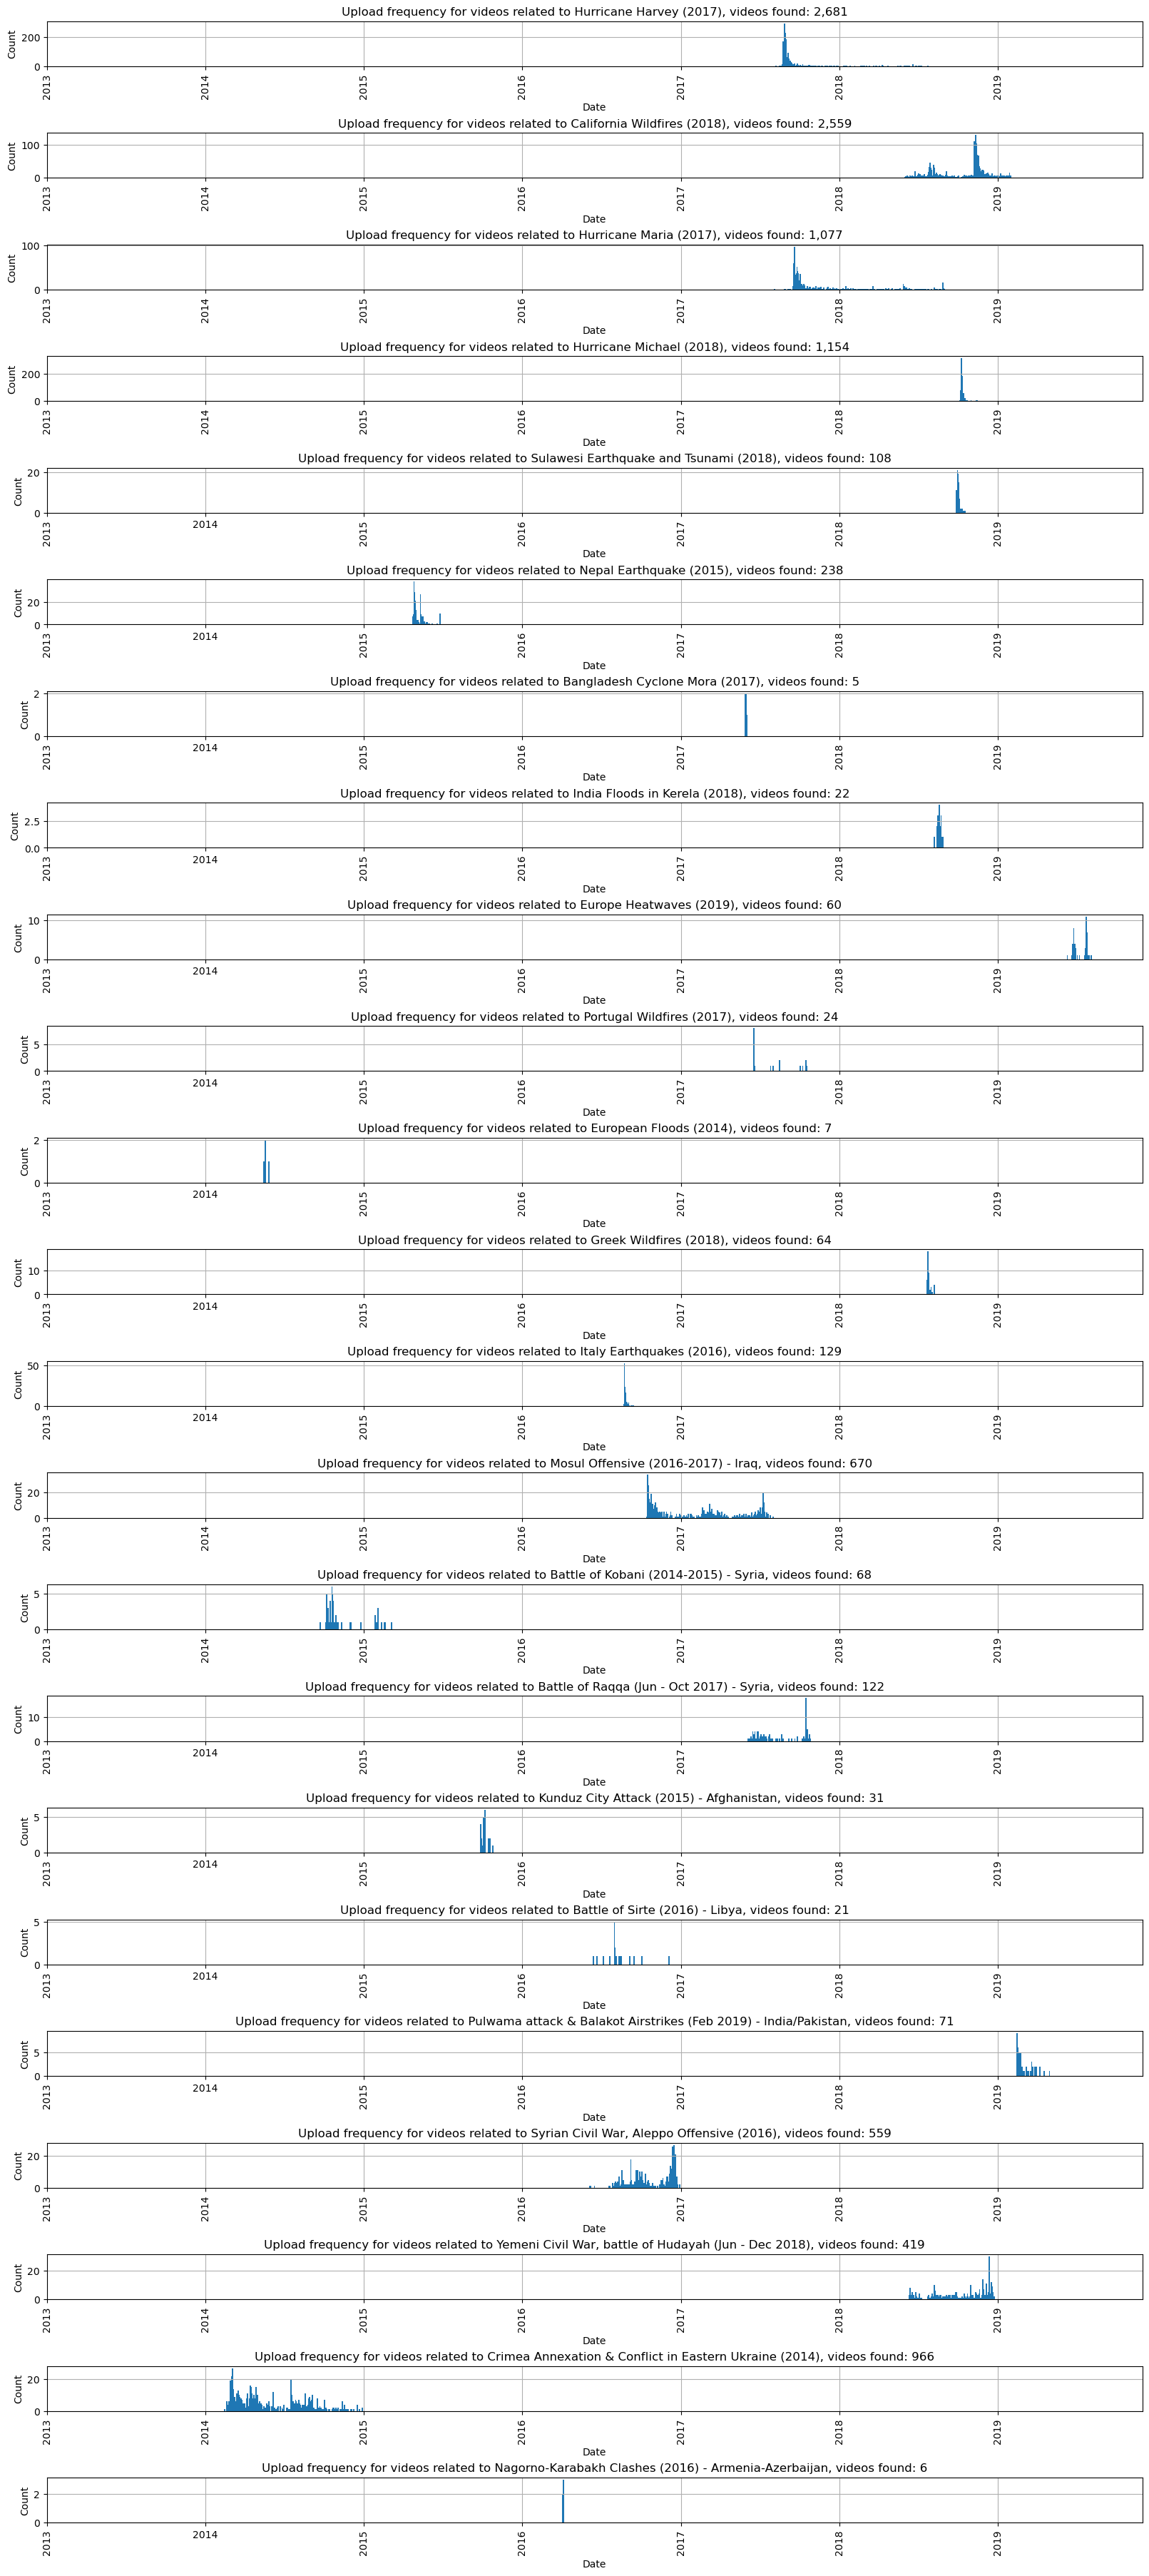

In [48]:
# plot the evolution of upload frequency for each event
importlib.reload(keywords)

"""
# all_plots = True to plot for all the events, disregards chosen index. Else plot for the even corresponding to chosen index
# grouping_mode: "daily", "weekly", "monthly"

 """
index = 4  # 0-N List is found in keywords.py

crop_time = True

metadata_2 = metadata.clone()

metadata_2 = metadata_2.filter(
    ~ ((metadata_2["channel_id"] == "UCKQECjul8nw1KW_JzfBTP1A")) # & (metadata_2["upload_date"] < date(2018, 4, 9)))
)

metadata_2 = metadata_2.filter(
   ~ ((metadata_2["channel_id"] == "UC_YFbvKedjnVjqrZqBR4L8Q")) #  & (metadata_2["upload_date"] < date(2018, 4, 9)))
)

metadata_2 = metadata_2.filter(                                                 # to remove completely
   ~ (metadata_2["channel_id"] == "UCN3me_2IdGN5C0QV5PubDlQ")
)

metadata_2 = metadata_2.filter(
    ~ ((metadata_2["channel_id"] == "UCupvZG-5ko_eiXAupbDfxWw") & (metadata_2["upload_date"] < date(2016, 7, 22)))
)

metadata_2 = metadata_2.filter(
    ~ ((metadata_2["channel_id"] == "UCXIJgqnII2ZOINSWNOGFThA"))
)

output = keywords.plot_update_freq(index, metadata_2, all_plots = True, grouping_mode = "daily", crop_time = crop_time, generate = True)     # function that can take individual terms (with or) and groups of terms (with and

In [49]:
# fix weird view count and save to csv
feather = pl.read_csv(path_final_yt_metadata_feather, has_header=True, separator=",")
output = output.drop("view_count")
output = output.join(feather[["display_id", "view_count"]], on="display_id", how="inner")
output.write_csv(path_event_yt_metadata, include_header=True, separator=",")

### 2.2 Visualize the event filtering process

In [50]:
df = pd.read_csv(path_event_yt_metadata)
filtering_visualization.sankey_plot_events(df, show=True, save_path="img/event_filtering_sankey.html")

## 3 How US News report on different events <a class="anchor" id="status_quo"></a>

In this section we are computing video features for the videos. They are:
- the duration of the video
- the appearance of keywords in the title ("update", "breaking", "footage")
- capitalization ratio of the title
- activity of the channel during +/- 2 weeks of the video upload
- subjectivity of the title


### 3.1 Extract video and channel features<a class="anchor" id="status_quo-features"></a>

In [51]:
from src.utils import live_keywords
from src.utils import analysis_tools
from src.utils.analysis_tools import *
importlib.reload(live_keywords)

# load feather metadata used to compute the actvity of the channel at the time of the event
feather_metadata = pl.read_csv(path_final_yt_metadata_feather)

# get the metadata filtered by the events containing the event, region and event_type
event_metadata = pl.read_csv(path_event_yt_metadata)

# TODO: Combine with comments stats
com_stats = pl.read_csv(path_comments_stats)
event_metadata = event_metadata.join(com_stats, on="display_id", how="inner")

# TODO: ADD IS LIVE; UPDATE, BREAKING
event_metadata = live_keywords.add_video_type(event_metadata, "footage")
event_metadata = live_keywords.add_video_type(event_metadata, "update")
event_metadata = live_keywords.add_video_type(event_metadata, "breaking")

# TODO: combine with subjectivity
subjectivity = pl.read_csv(path_subjectivity)
event_metadata = event_metadata.join(subjectivity[["display_id", "subjectivity"]], on="display_id", how="inner")
event_metadata.sample(1)

categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,event,region,event_type,view_count,num_comments,total_likes,num_replies,is_footage,_update_,_breaking_,subjectivity
str,str,str,str,f64,str,i64,f64,str,str,str,str,str,str,f64,i64,i64,i64,bool,bool,bool,f64
"""People & Blogs""","""UCJCreS7pODbA6XYRsI5fdLg""","""2019-10-31 18:03:00.775162""","""Before Hurricane Harvey hit, g…",0.0,"""Ot8qLbn0olI""",127,2.0,"""News,Local""","""Gas prices rise after Harvey h…","""2017-09-08""","""Hurricane Harvey (2017)""","""US""","""environmental""",25.0,0,0,0,false,false,false,0.2


In [52]:
# create the video features dataframe for the event and merge with existing metadata
vid_features = create_video_features_dataframe(event_metadata, feather_metadata)
metadata_features_df = event_metadata.join(vid_features, on="display_id", how="inner")
features_columns = ["duration", "channel_activity", "capitalisation_ratio", "subjectivity", "is_footage", "_update", "_breaking_"]
metadata_features_df.sample(2)

categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,event,region,event_type,view_count,num_comments,total_likes,num_replies,is_footage,_update_,_breaking_,subjectivity,channel_activity,capitalisation_ratio
str,str,str,str,f64,str,i64,f64,str,str,str,str,str,str,f64,i64,i64,i64,bool,bool,bool,f64,f64,f64
"""News & Politics""","""UC8p1vwvWtl6T73JiExfWs1g""","""2019-11-08 07:48:04.431458""","""Texas is bracing for catastrop…",2.0,"""zZHcyT2CeyQ""",207,50.0,"""video,live streaming,live vide…","""Texas prepares for Hurricane H…","""2017-08-24""","""Hurricane Harvey (2017)""","""US""","""environmental""",7675.0,48,86,30,false,false,false,0.0,19.137931,0.096774
"""News & Politics""","""UCVSNOxehfALut52NbkfRBaA""","""2019-11-02 01:35:53.346219""","""Many parts of the world are ex…",1.0,"""xSBmbeyCvQs""",142,7.0,"""climate change""","""Study: Unusual Heat Waves to B…","""2018-08-08""","""Greek Wildfires (2018)""","""Europe""","""environmental""",222.0,0,0,0,false,false,false,0.3,9.310345,0.181818


In [ ]:
# add the response metrics for the event to the dataframe
metadata_features__response_df = analysis_tools.create_response_metrics_df(metadata_features_df)
response_columns = ["view_count", "comments/view", "likes-dislikes/views", "replies/comment"]
# save the dataframe to a csv file
metadata_features__response_df.write_csv("data/final_all_features_and_metrics.csv", include_header=True, separator=",")
metadata_features__response_df.sample(2)

categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,event,region,event_type,view_count,num_comments,total_likes,num_replies,is_footage,_update_,_breaking_,subjectivity,channel_activity,capitalisation_ratio,likes-dislikes/views,replies/comment,comments/view
str,str,str,str,f64,str,i64,f64,str,str,str,str,str,str,f64,i64,i64,i64,bool,bool,bool,f64,f64,f64,f64,f64,f64
"""People & Blogs""","""UC1JAwKeDUjN2orv5t7LWODQ""","""2019-11-20 06:49:06.183498""","""TX couple welcomes twins durin…",0.0,"""U8suwlalXWs""",118,0.0,"""News""","""TX couple welcomes twins durin…","""2017-09-01""","""Hurricane Harvey (2017)""","""US""","""environmental""",35.0,0,0,0,false,false,false,0.2,19.758621,0.095238,0.0,0.0,0.0
"""News & Politics""","""UCaXkIU1QidjPwiAYu6GcHjg""","""2019-11-06 18:56:57.173170""","""Former U.S. Coast Guard Admira…",16.0,"""0Erhs6KOPrs""",117,61.0,"""MSNBC,news channel,breaking ne…","""Hurricane Maria's Aftermath Di…","""2017-09-29""","""Hurricane Maria (2017)""","""US""","""environmental""",20143.0,0,0,0,false,false,false,0.2,14.827586,0.217391,0.002234,0.0,0.0


#### 2.2.1 Initial distributions of video metrics <a class="anchor" id="status_quo-features-distributions"></a>
In this section we want to show the distributions of all available video metrics. These metrics will later be used to catergorize the videos and the user resopnse to them. The plots here below are show the overall distribution over the whole filtered dataset, they build the baseline we can compare the response to specific events against.

In [ ]:
#plotting numerical distributions
analysis_tools.plot_video_stat(event_metadata, 'view_count')
analysis_tools.plot_video_stat(event_metadata, 'duration')
analysis_tools.plot_video_stat(event_metadata, 'like_count')
analysis_tools.plot_video_stat(event_metadata, 'dislike_count')

In [ ]:
#plotting common words
analysis_tools.plot_most_common_tags(event_metadata, 30)
analysis_tools.plot_most_common_words(event_metadata, 'title', 30)
analysis_tools.plot_most_common_words(event_metadata, 'description', 30)

In [ ]:
#plotting the length of titles and discriptions
analysis_tools.plot_text_len_words(event_metadata, 'title')
analysis_tools.plot_text_len_words(event_metadata, 'description')

## 3 How does the public response to events <a class="anchor" id="public_response"></a>

### 3.1 Compute Public Response Metrics <a class="anchor" id="public_response-metrics"></a>

### 3.2 Compute Correlation between Video Features and Response Metrics for Different Groupings of the Data <a class="anchor" id="public_response-correlation"></a>

In [3]:
#load the final features and metrics dataframe
features_and_metrics = pl.read_csv(path_final_all_features_and_metrics, separator=",", has_header=True)

In [4]:
#define the video features and metrics to be used in the analysis
features = ['duration', 'is_footage', '_update_', '_breaking_', 'capitalisation_ratio', 'channel_activity', 'subjectivity']
metrics = ['view_count', 'num_comments', 'replies/comment','likes-dislikes/views']

In [5]:
from src.utils.analysis_tools import compute_correlation_for_group

#compute the correlation for the different event groupings
#the how_to_group parameter can be set to 'event', 'event_type' or 'region'
correlations, pvalues, list_of_event_groupings = compute_correlation_for_group(features_and_metrics, 'event', features, metrics, standardize=False)

c:\Users\samue\Desktop\Box Sync\3.Samuel\Uni_24-25\ADA\ada-2024-project-lil0mohammadali\src\utils\analysis_tools.py:605: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr[i,j], pvals[i,j] = stats.pearsonr(df_standardized[i], df_standardized[j])


In [7]:
#plot the correlation matrix for all event groupings
fig = plot_correlation_for_groups_of_events(correlations, pvalues, features, metrics, list_of_event_groupings, title = 'Correlation Matrix of Video Features and Response Metrics for all Events')

In [50]:
#save the plot as an html file for the website

#fig.write_html("../ada-datastory-website/assets/plots/correlation_matrix_events.html")

## 4 Regression analysis <a class="anchor" id="conclusion"></a>

In [ ]:
import polars as pl
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#load dataframe
df = pl.read_csv("final_all_features_and_metrics.csv")

#preprocess columns to be used in the model
df = df.to_pandas() #convert to pandas dataframe
df.drop(columns = df.loc[:, "channel_id" : "description"].columns, axis = 1, inplace=True) #drop columns that are not needed
df.drop("tags", axis = 1, inplace=True) #drop tags column


columns_to_standardize = ['subjectivity', 'duration', 'channel_activity', 'capitalisation_ratio'] #define columns to standardize
scaler = StandardScaler() #initialize standard scaler
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize]) #standardize columns

In [ ]:
#rename columns
df.rename(columns={
    'likes-dislikes/views': 'likes_dislikes_per_view',
    'replies/comment': 'replies_per_comment',
    'likes/comment': 'likes_per_comment'
}, inplace=True)

# add the comments per view metric
df['comments_per_views'] = df['num_comments'] / df['view_count']


# Define the dependent variables and the independent variables
# Create a list in order to iterate over them
dependent_vars = [
    'view_count', 
    'likes_dislikes_per_view', 
    'replies_per_comment', 
    'comments_per_views'
]

independent_formula_part = (
    "subjectivity + duration + channel_activity + capitalisation_ratio + "
    "C(is_footage) + C(_breaking_) + C(_update_)"
)

#fix random seed
np.random.seed(2)

# Create a figure to plot the results
fig, axs = plt.subplots(2, 2, figsize=(14, 14))
axs = axs.ravel()  # Flatten to iterate easily

colors = {'environmental': 'blue', 'geopolitical': 'red'} # Define colors for each event type

for i, dv in enumerate(dependent_vars):
    ax = axs[i]

    y_labels = []
    y_positions = []
    position_offset = 0

    max_r2 = 0  # Track maximum R^2 for the current dependent variable

    for j, (event_type, color) in enumerate(colors.items()):\

        filtered_df = df[df['event_type'] == event_type]
        
        formula = f"{dv} ~ {independent_formula_part}"
        mod = smf.ols(formula=formula, data=filtered_df) 
        res = mod.fit()

        r2 = res.rsquared
        max_r2 = max(max_r2, r2)

        variables = res.params.index
        coefficients = res.params.values
        p_values = res.pvalues.values
        standard_errors = res.bse.values

        sorted_results = sorted(
            zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:]), 
            key=lambda x: x[1]
        )
        l1, l2, l3, l4 = zip(*sorted_results)

        event_positions = np.arange(len(l1)) + position_offset
        position_offset += 0.2

        for idx, (v, coef, pv) in enumerate(zip(l2, l1, l4)):
            if j == 0:  # Add variable name only once
                y_labels.append(f"{v}")
                y_positions.append(event_positions[idx] - 0.2)
            y_labels.append(f"Coef={coef:.3f}, p={pv:.3g}")
            y_positions.append(event_positions[idx])

        # Plot coefficients with error bars (2*std_err for 95% CI)
        ax.errorbar(l1, event_positions, xerr=2*np.array(l3),
                    linewidth=1, linestyle='none', marker='o', markersize=3,
                    markerfacecolor=color, markeredgecolor=color, capsize=5, label=f'{event_type}')

    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels, ha='right', color='black')

    # Add zero reference line and set titles
    ax.axvline(x=0, linestyle='--', color='grey', linewidth=1)
    ax.set_title(f"{dv} (R^2={max_r2:.2f})", fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.xaxis.grid(True, linestyle='--', color='gray', linewidth=0.7, alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()

## 5 Conclusion <a class="anchor" id="conclusion"></a>

In this notebook, we filtered the channels, metadata and times-series by keeping the videos from US, English-speaking channels with the category of News and Politics, keeping only high activity channels. Filtering of the massive comments dataset from these channels will be done on AWS, and we will study the reporting of the different events, ultimate grouping them by event category and country of occurrence to draw meaningful patterns, and we will also study how different video formats, types, and other characteristics affect the response of the public in terms of virality as well as the breadth of discussions that are illicited in the comments. We were able to isolate the videos related to each event by writing a list of terms that are respectively relevant to said events (while minimizing overlapping with other events as to not flag irrelevant videos), and searching for them in the titles and descriptions.